In [1]:
from google.colab import files
uploaded = files.upload()

Saving ML_Input_Matrix.csv to ML_Input_Matrix.csv


In [2]:
import pandas as pd

# Load your training matrix
df = pd.read_csv("ML_Input_Matrix.csv", index_col=0)

# Check columns
print(df.columns[-5:])  # confirm where Group column is

# Check class distribution
print(df["Group"].value_counts())

# Percentage distribution
print(df["Group"].value_counts(normalize=True) * 100)

Index(['CAPSL', 'ZBBX', 'IGLV3-10', 'IGKV4-1', 'Group'], dtype='object')
Group
Tumor     268
Normal    242
Name: count, dtype: int64
Group
Tumor     52.54902
Normal    47.45098
Name: proportion, dtype: float64


## **Phase 1: Load Data abd Define X, Y**

In [3]:
import pandas as pd
import numpy as np

# Load merged training matrix (510 samples × 551 genes)
df = pd.read_csv("ML_Input_Matrix.csv", index_col=0)

# Encode binary outcome (Normal=0, Tumor=1)
df["Group"] = df["Group"].map({"Normal": 0, "Tumor": 1})

# Separate predictors and target
X = df.drop(columns=["Group"])
y = df["Group"]

print("Shape:", X.shape)
print("Class distribution:\n", y.value_counts())

Shape: (510, 550)
Class distribution:
 Group
1    268
0    242
Name: count, dtype: int64


## Phase 2: Stratified Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split

# Create internal hold-out set (20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (408, 550)
Test shape: (102, 550)


## Phase 3: Define ML Models (Scaling Inside Pipeline)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Define candidate models for comparison
models = {

    # Baseline linear classifier
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000))
    ]),

    # L1-regularized model (embedded feature selection)
    "LASSO": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty="l1",
                                   solver="saga",
                                   max_iter=5000))
    ]),

    # ElasticNet (L1 + L2 regularization)
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty="elasticnet",
                                   solver="saga",
                                   l1_ratio=0.5,
                                   max_iter=5000))
    ]),

    # Non-linear ensemble model
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        random_state=42
    ),

    # Kernel-based classifier
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True))
    ]),

    # Gradient boosting model
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )
}

## Phaase 4: 5 Fold Stratified Cross-Validation

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Stratified 5-fold CV for fair comparison
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():

    # Evaluate model using ROC-AUC
    scores = cross_val_score(model, X_train, y_train,
                             cv=cv,
                             scoring="roc_auc")

    results[name] = (scores.mean(), scores.std())

    print(f"{name}: AUC = {scores.mean():.3f} ± {scores.std():.3f}")

Logistic: AUC = 0.941 ± 0.022
LASSO: AUC = 0.929 ± 0.017
ElasticNet: AUC = 0.932 ± 0.020
RandomForest: AUC = 0.960 ± 0.012
SVM: AUC = 0.952 ± 0.018


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:27:39] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:27:41] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:27:43] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:27:45] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:

XGBoost: AUC = 0.954 ± 0.010


# Roc Curve ElasticNet (Hold-Out set)

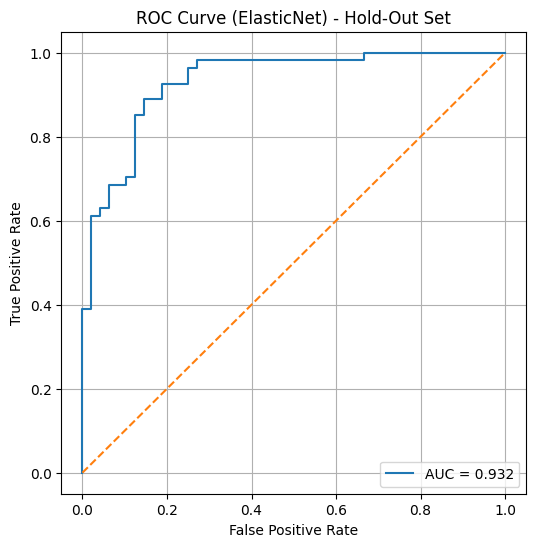

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Fit model
best_model = models["ElasticNet"]
best_model.fit(X_train, y_train)

# Predict probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ElasticNet) - Hold-Out Set")
plt.legend()
plt.grid()
plt.show()

# ROC Curve RandomForest (Hold-Out set)

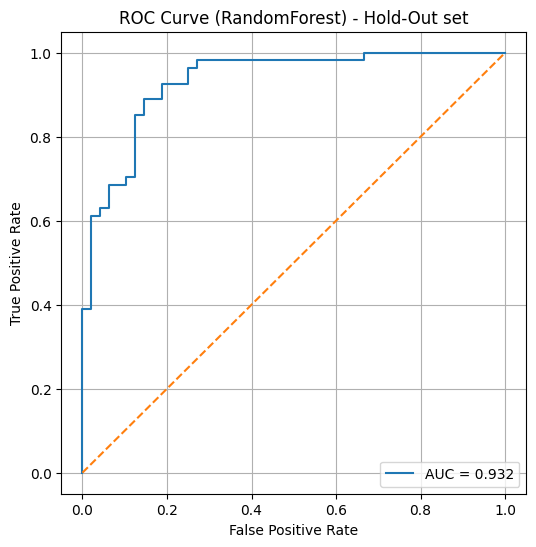

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Fit model
best_model = models["ElasticNet"]
best_model.fit(X_train, y_train)

# Predict probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RandomForest) - Hold-Out set")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix

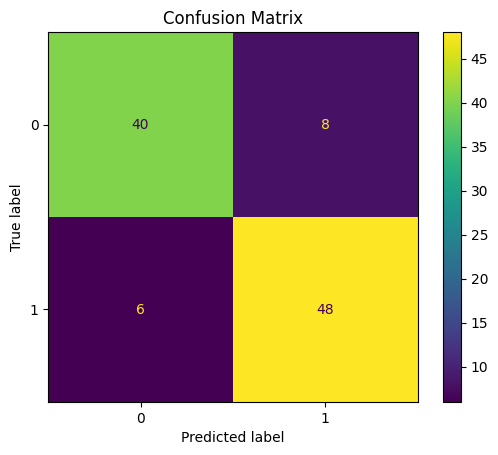

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to class labels
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve

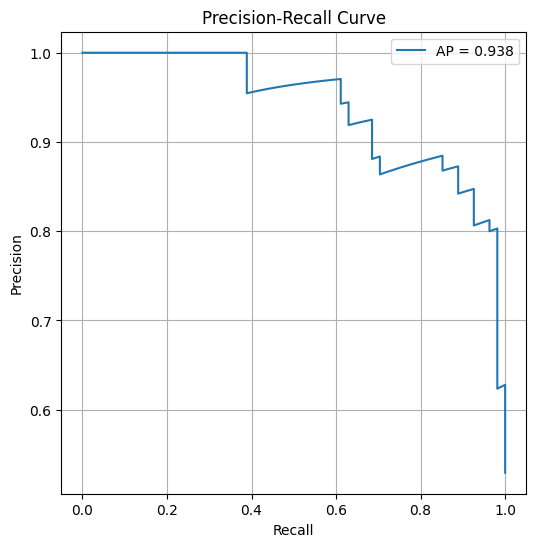

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Compared ROC Curves of All Models

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:41:16] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


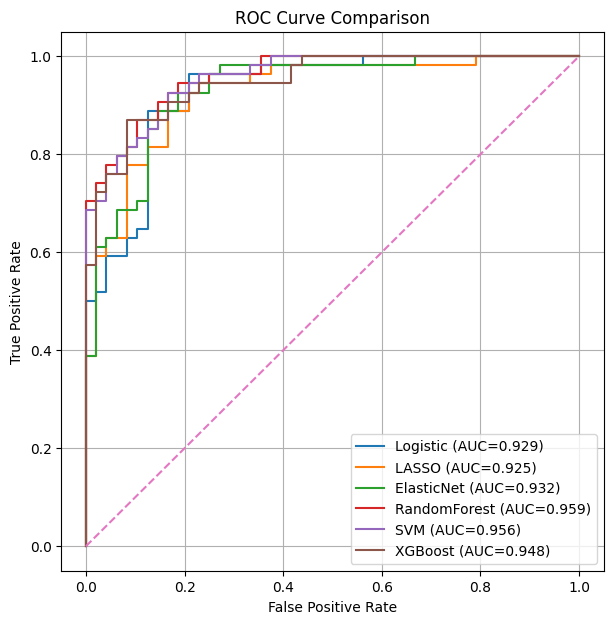

In [15]:
plt.figure(figsize=(7,7))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

# Random Forest Feature Important Plot

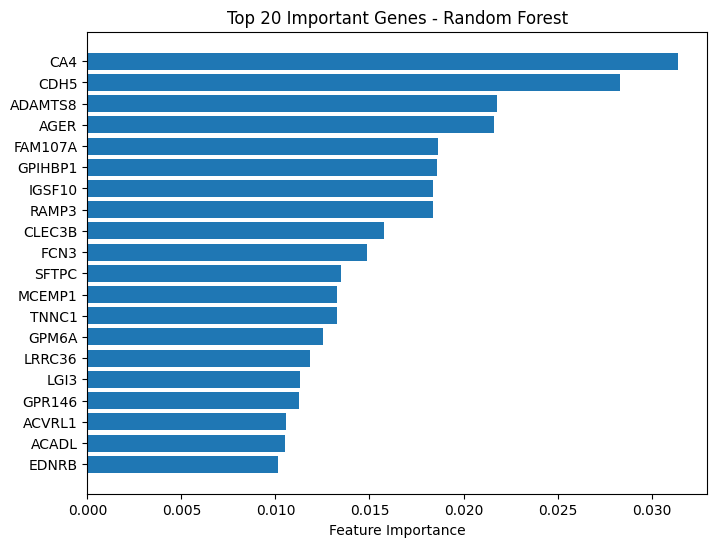

In [16]:
import numpy as np

rf = models["RandomForest"]
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 genes

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Genes - Random Forest")
plt.show()

# Model Performance Bar Plot (CV AUC +_ SD)

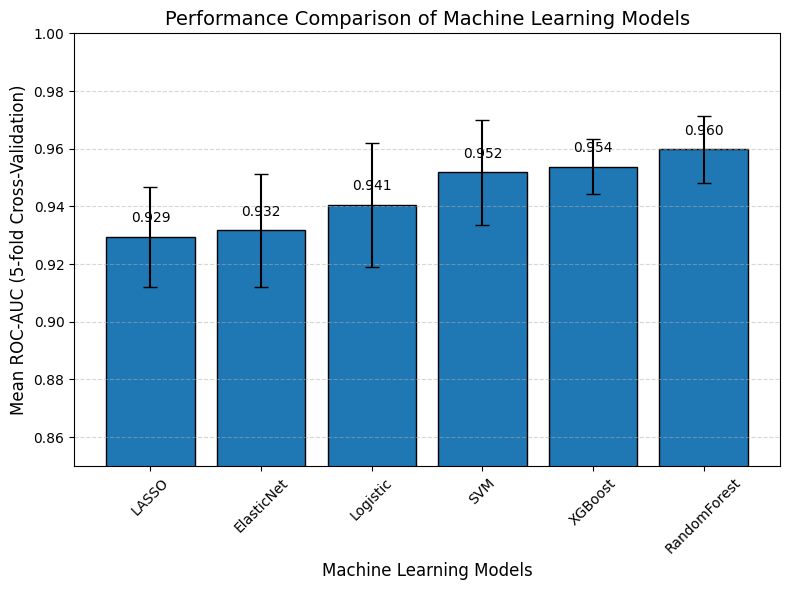

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model performance
model_names = list(results.keys())
mean_auc = np.array([results[m][0] for m in model_names])
std_auc = np.array([results[m][1] for m in model_names])

# Sort models by mean AUC (ascending for clarity)
sorted_idx = np.argsort(mean_auc)
model_names = np.array(model_names)[sorted_idx]
mean_auc = mean_auc[sorted_idx]
std_auc = std_auc[sorted_idx]

# Create figure
plt.figure(figsize=(8,6))

bars = plt.bar(model_names,
               mean_auc,
               yerr=std_auc,
               capsize=5,
               edgecolor='black',
               linewidth=1)

# Annotate exact AUC values above bars
for bar, auc in zip(bars, mean_auc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.004,
             f"{auc:.3f}",
             ha='center',
             va='bottom',
             fontsize=10)

# Scientific formatting
plt.ylabel("Mean ROC-AUC (5-fold Cross-Validation)", fontsize=12)
plt.xlabel("Machine Learning Models", fontsize=12)
plt.title("Performance Comparison of Machine Learning Models", fontsize=14)

plt.ylim(0.85, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Save high-quality files (300 dpi)
plt.savefig("Model_Comparison_AUC_300dpi.png", dpi=300, bbox_inches='tight')
plt.savefig("Model_Comparison_AUC_300dpi.tiff", dpi=300, bbox_inches='tight')

plt.show()

## PHASE 1 — ElasticNet Stability Selection (30 Repeats)
What we do:
*   5-fold Stratified CV.
*   Repeat 30 times (different random seeds).

In each fold:
*   Fit ElasticNet
*   Record genes with non-zero coefficients
*   Count selection frequency

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize frequency counter
gene_names = X_train.columns
selection_counts = pd.Series(0, index=gene_names)

n_repeats = 30
n_splits = 5

for repeat in range(n_repeats):

    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=repeat)

    for train_idx, val_idx in cv.split(X_train, y_train):

        X_fold = X_train.iloc[train_idx]
        y_fold = y_train.iloc[train_idx]

        # ElasticNet model
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                l1_ratio=0.5,
                max_iter=5000
            ))
        ])

        model.fit(X_fold, y_fold)

        # Extract coefficients
        coefs = model.named_steps["clf"].coef_[0]

        # Identify non-zero genes
        selected_genes = gene_names[coefs != 0]

        # Update selection count
        selection_counts[selected_genes] += 1

# Convert to frequency
selection_frequency = selection_counts / (n_repeats * n_splits)

# Sort genes by stability
selection_frequency = selection_frequency.sort_values(ascending=False)

selection_frequency.head(20)

,0
CD69,1.000000
CHI3L2,1.000000
GLIPR2,1.000000
AKR1B10,1.000000
PTX3,1.000000
SPINK1,0.993333
NDNF,0.993333
SASH1,0.993333
VSIG4,0.993333
TMPRSS4,0.993333


In [20]:
top50_genes = selection_frequency.head(50).index.tolist()

## Saving the top 50 Genes

In [25]:
from google.colab import files
import pandas as pd

# Convert to DataFrame and format properly
top50_df = selection_frequency.head(50).reset_index()
top50_df.columns = ["Gene", "Selection_Frequency"]

# Save CSV
top50_df.to_csv("Top50_ElasticNet_Stable_Biomarkers.csv", index=False)

# Download to local system
files.download("Top50_ElasticNet_Stable_Biomarkers.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Now Evaluate Random Forest, XGBoost, and SVM using only these to 50 genes

# Step 1: Subset Data to Top 50 Genes

In [26]:
# Load top 50 genes
top50_df = pd.read_csv("Top50_ElasticNet_Stable_Biomarkers.csv")

top50_genes = top50_df["Gene"].tolist()

# Subset training and test sets
X_train_50 = X_train[top50_genes]
X_test_50  = X_test[top50_genes]

print("Training shape (Top 50):", X_train_50.shape)
print("Test shape (Top 50):", X_test_50.shape)

Training shape (Top 50): (408, 50)
Test shape (Top 50): (102, 50)


# Step 2: Define Models

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

models_50 = {
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        random_state=42
    ),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True))
    ]),

    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}

# Step 3: Evaluate on Hold-Out Set

In [28]:
from sklearn.metrics import roc_auc_score

results_50 = {}

for name, model in models_50.items():

    model.fit(X_train_50, y_train)

    y_prob = model.predict_proba(X_test_50)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    results_50[name] = auc
    print(f"{name} (Top 50 genes) AUC = {auc:.3f}")

RandomForest (Top 50 genes) AUC = 0.954
SVM (Top 50 genes) AUC = 0.954
XGBoost (Top 50 genes) AUC = 0.948


# ROC Curve- Top 50 Panel (Hold-Out)

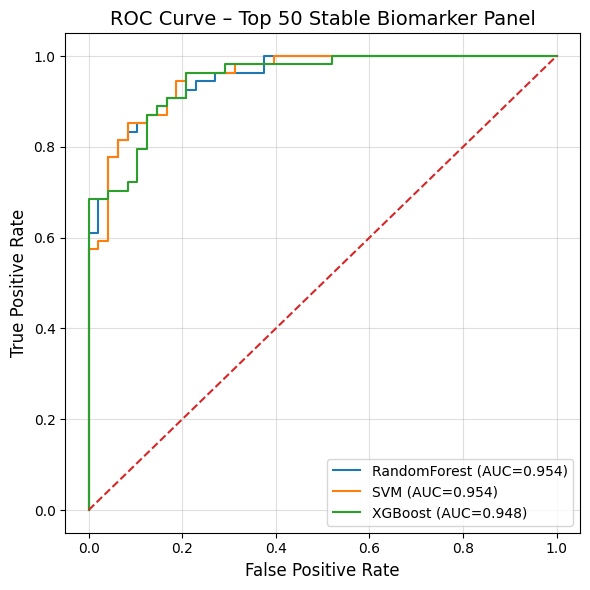

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(6,6))

for name, model in models_50.items():

    model.fit(X_train_50, y_train)
    y_prob = model.predict_proba(X_test_50)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve – Top 50 Stable Biomarker Panel", fontsize=14)
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.savefig("ROC_Top50_Internal_300dpi.png", dpi=300)
plt.show()

# Heatmap of Top 50 genes (Tumor vs Normal)

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

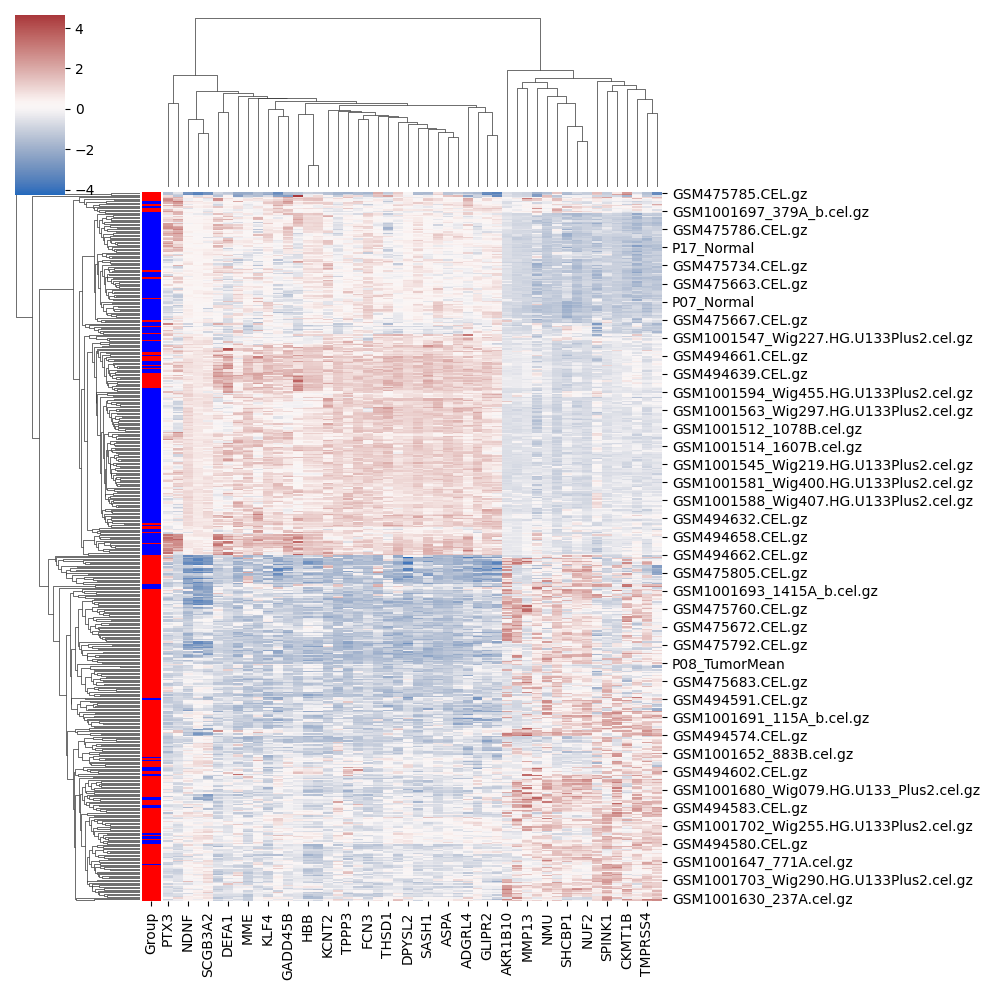

In [30]:
import seaborn as sns

# Combine train+test for visualization only
X_all_50 = pd.concat([X_train_50, X_test_50])
y_all = pd.concat([y_train, y_test])

# Standardize for visualization
X_scaled = (X_all_50 - X_all_50.mean()) / X_all_50.std()

plt.figure(figsize=(12,8))
sns.clustermap(
    X_scaled,
    row_colors=y_all.map({0:"blue", 1:"red"}),
    cmap="vlag",
    figsize=(10,10)
)

plt.savefig("Heatmap_Top50_Genes_300dpi.png", dpi=300)

# Stability Plot

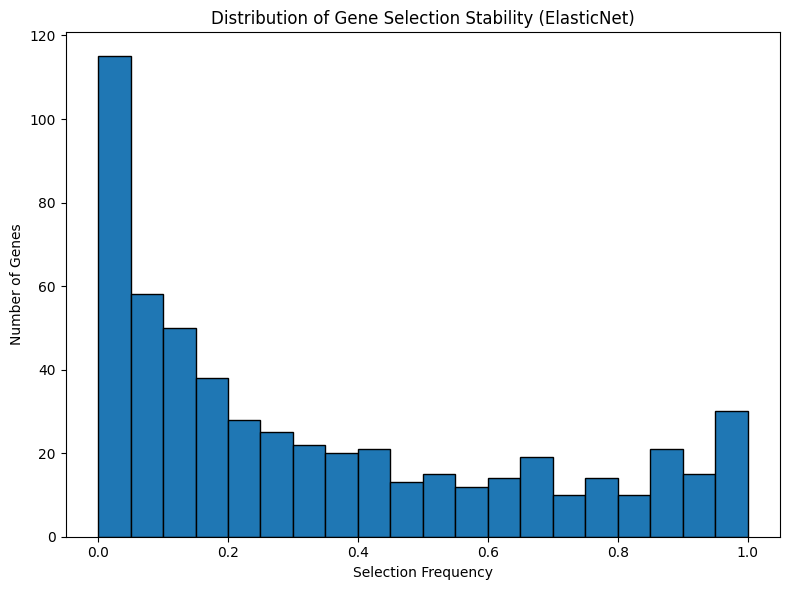

In [31]:
plt.figure(figsize=(8,6))

plt.hist(selection_frequency.values, bins=20, edgecolor='black')

plt.xlabel("Selection Frequency")
plt.ylabel("Number of Genes")
plt.title("Distribution of Gene Selection Stability (ElasticNet)")

plt.tight_layout()
plt.savefig("Stability_Distribution_300dpi.png", dpi=300)
plt.show()

# Top 20 Stability Bar Plot

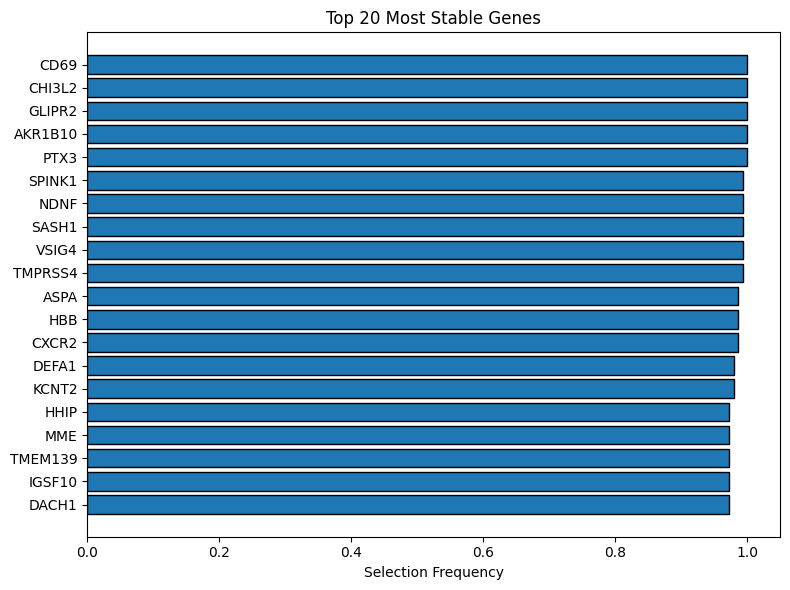

In [32]:
top20 = selection_frequency.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20.index[::-1], top20.values[::-1], edgecolor='black')

plt.xlabel("Selection Frequency")
plt.title("Top 20 Most Stable Genes")

plt.tight_layout()
plt.savefig("Top20_Stability_300dpi.png", dpi=300)
plt.show()

# **External Validation with GSE18842**

# Step 1:Load External dataset

In [33]:
from google.colab import files
uploaded = files.upload()

Saving GSE18842_ML_Validation_Matrix.csv to GSE18842_ML_Validation_Matrix.csv


In [34]:
import pandas as pd

# Load dataset
external_df = pd.read_csv("GSE18842_ML_Validation_Matrix.csv")

print("Shape:", external_df.shape)
external_df.head()

Shape: (91, 12763)


/tmp/ipython-input-583/1627875833.py:4: DtypeWarning: Columns (12762) have mixed types. Specify dtype option on import or set low_memory=False.
  external_df = pd.read_csv("GSE18842_ML_Validation_Matrix.csv")


,Unnamed: 0,DDR1,RFC2,HSPA6,UBA7,PTPN21,CCL5,EPHB3,ESRRA,SCARB1,...,BTG1-DT,SNORD50A,TMIGD2,ZNF667-AS1,LOC400499,GALR3,SAP25,TMEM231,Group,PatientID
0,GSM466947.CEL.gz,10.908731,8.445164,6.476229,6.608513,4.424705,9.660465,7.052473,7.642435,5.709284,...,5.820316,6.396618,6.521976,4.202545,5.986805,5.966307,5.687941,5.662241,Tumor,2
1,GSM466948.CEL.gz,9.366067,7.112511,6.925584,8.486080,6.071568,10.326797,5.510271,7.148062,5.298177,...,5.427238,6.693192,7.059213,6.250882,5.618860,5.875170,6.109415,5.495099,Normal,2
2,GSM466949.CEL.gz,10.933076,8.774764,9.512552,6.136805,4.095666,7.830085,8.250510,7.169325,6.520874,...,5.424331,6.808476,6.739063,3.827454,5.779611,6.259681,5.680274,4.731241,Tumor,3
3,GSM466950.CEL.gz,9.216703,7.476967,7.839092,8.379130,5.405873,9.088741,5.387806,7.318060,5.367231,...,5.902283,6.984180,6.810992,5.862236,5.796650,5.568671,6.292438,6.891932,Normal,3
4,GSM466951.CEL.gz,9.445010,6.909653,8.196972,8.343369,4.530190,10.653833,6.102131,6.888310,5.756446,...,6.421155,6.885506,7.030463,5.910250,6.175636,5.334667,6.260207,4.921426,Tumor,6


# Step 2:Separaete Features and Labels

In [35]:
# Separate expression matrix and labels
X_ext = external_df.drop("Group", axis=1)
y_ext = external_df["Group"]

# Encode labels same as training
y_ext = y_ext.map({"Normal": 0, "Tumor": 1})

print("External feature shape:", X_ext.shape)
print("Label distribution:\n", y_ext.value_counts())

External feature shape: (91, 12762)
Label distribution:
 Group
1    46
0    45
Name: count, dtype: int64


# Step 3: Check Gene Overlap

In [36]:
# Check overlap with Top 50 genes
common_genes = [g for g in top50_genes if g in X_ext.columns]
missing_genes = [g for g in top50_genes if g not in X_ext.columns]

print("Number of overlapping genes:", len(common_genes))
print("Number of missing genes:", len(missing_genes))

if len(missing_genes) > 0:
    print("Missing genes:", missing_genes)

Number of overlapping genes: 49
Number of missing genes: 1
Missing genes: ['RGS17']


# Step 4- Subset External Dataset

In [37]:
# Subset to overlapping genes
X_ext_50 = X_ext[common_genes]

print("External validation matrix shape:", X_ext_50.shape)

External validation matrix shape: (91, 49)


In [38]:
# Ensure exact same order as training
common_genes_ordered = [g for g in top50_genes if g in X_ext.columns]
X_ext_50 = X_ext_50[common_genes_ordered]

# Step 5: Train Final ElasticNet and RandomForest Model on Full training Set and Predicting on External Dataset

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Create training data subset with only common genes for consistent feature set
X_train_common = X_train[common_genes]

# Train ElasticNet model on the common gene set
final_enet_corrected = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        max_iter=5000,
        random_state=42
    ))
])
final_enet_corrected.fit(X_train_common, y_train) # Use X_train_common

# Train Random Forest model on the common gene set
final_rf_corrected = RandomForestClassifier(
    n_estimators=500,
    random_state=42
)
final_rf_corrected.fit(X_train_common, y_train) # Use X_train_common

# ElasticNet prediction with corrected model
y_ext_prob_enet = final_enet_corrected.predict_proba(X_ext_50)[:, 1]
external_auc_enet = roc_auc_score(y_ext, y_ext_prob_enet)

# Random Forest prediction with corrected model
y_ext_prob_rf = final_rf_corrected.predict_proba(X_ext_50)[:, 1]
external_auc_rf = roc_auc_score(y_ext, y_ext_prob_rf)

print("External AUC (ElasticNet) =", round(external_auc_enet, 3))
print("External AUC (Random Forest) =", round(external_auc_rf, 3))

External AUC (ElasticNet) = 0.994
External AUC (Random Forest) = 1.0


# Sanity Checks

In [43]:
print(y_ext.value_counts())
print(y_ext.unique())

Group
1    46
0    45
Name: count, dtype: int64
[1 0]


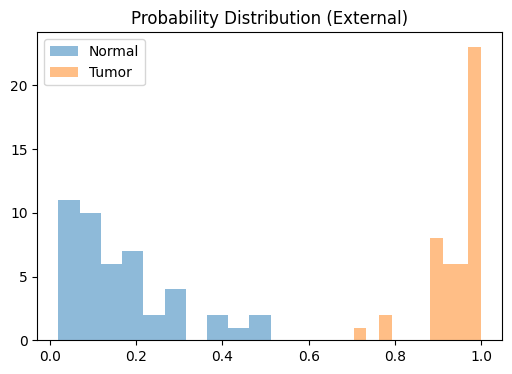

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(y_ext_prob_rf[y_ext==0], alpha=0.5, label="Normal")
plt.hist(y_ext_prob_rf[y_ext==1], alpha=0.5, label="Tumor")
plt.legend()
plt.title("Probability Distribution (External)")
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix

y_ext_pred = final_rf_corrected.predict(X_ext_50)

cm = confusion_matrix(y_ext, y_ext_pred)
print(cm)

[[43  2]
 [ 0 46]]


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_ext, y_ext_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       0.96      1.00      0.98        46

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91

